## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

## Calibration

Do camera calibration given object points and image points. Calculate warp and unwarp matrix. 


In [2]:
# prepare object points
nx = 9  # the number of inside corners in x
ny = 6  # the number of inside corners in y

obj_p = np.zeros((nx*ny, 3), np.float32)
obj_p[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d points in real world space
img_points = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #Find the chessboard corners
    # If corners are found, add object points and image points
    if ret == True:
        obj_points.append(obj_p)
        img_points.append(corners)

# Do camera calibration given object points and image points
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)

# Draw and dissplay the corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #Find the chessboard corners
    if ret == True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret) # Draw and display corners
        cv2.imshow('img',img)
        cv2.waitKey(100)        
cv2.destroyAllWindows()

#### Undistort Image

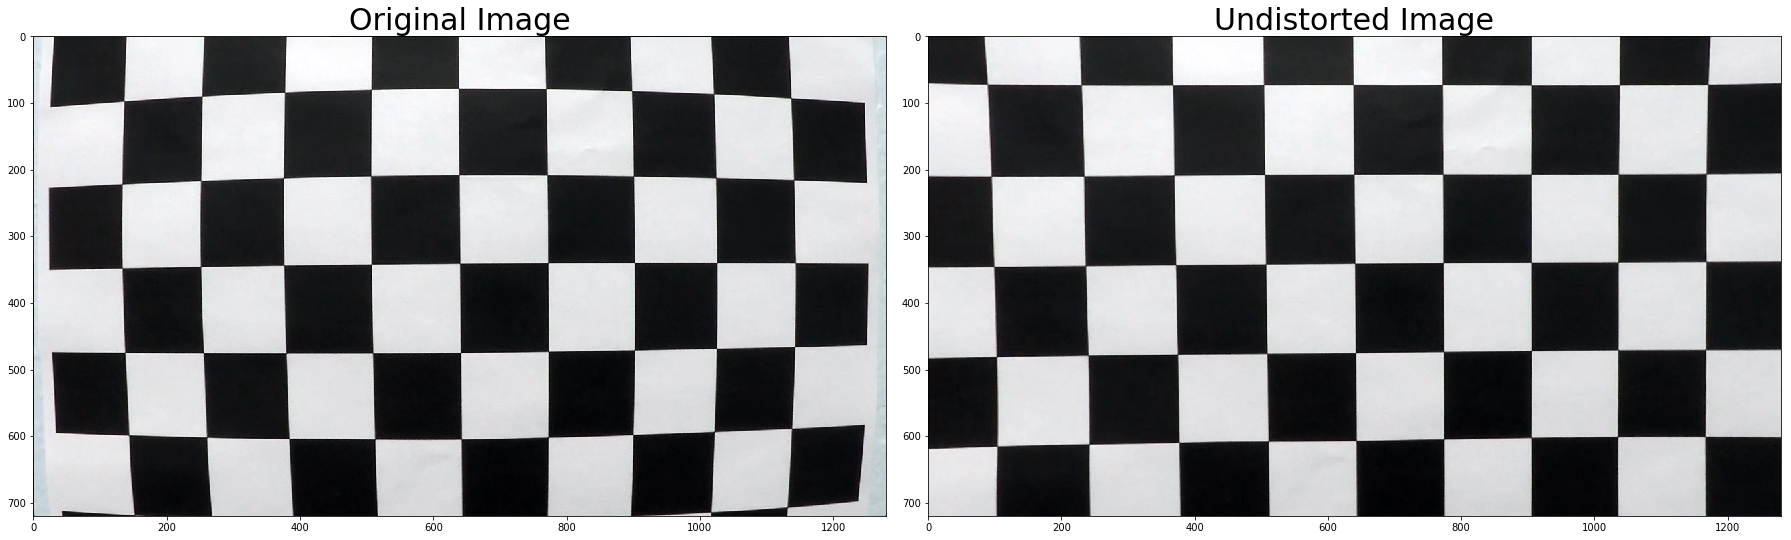

In [3]:
# Visualize original and undistorted image of one frame.
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize = 30)


#### Perspective Transform

In [4]:
def warp_image(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img

In [5]:
# Calculate warp and unwarp matrix
src = np.float32([[570, 470], [220, 720], [1110, 720], [720, 470]])
dst = np.float32([[320, 0], [320, 720], [920, 720], [920, 0]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
# Save the camera calibration result
calibration_pickle = {}
calibration_pickle["mtx"] = mtx
calibration_pickle["dist"] = dist
calibration_pickle['M'] = M
calibration_pickle['M_inv'] = M_inv
pickle.dump(calibration_pickle, open("calibration_result.p", "wb"))

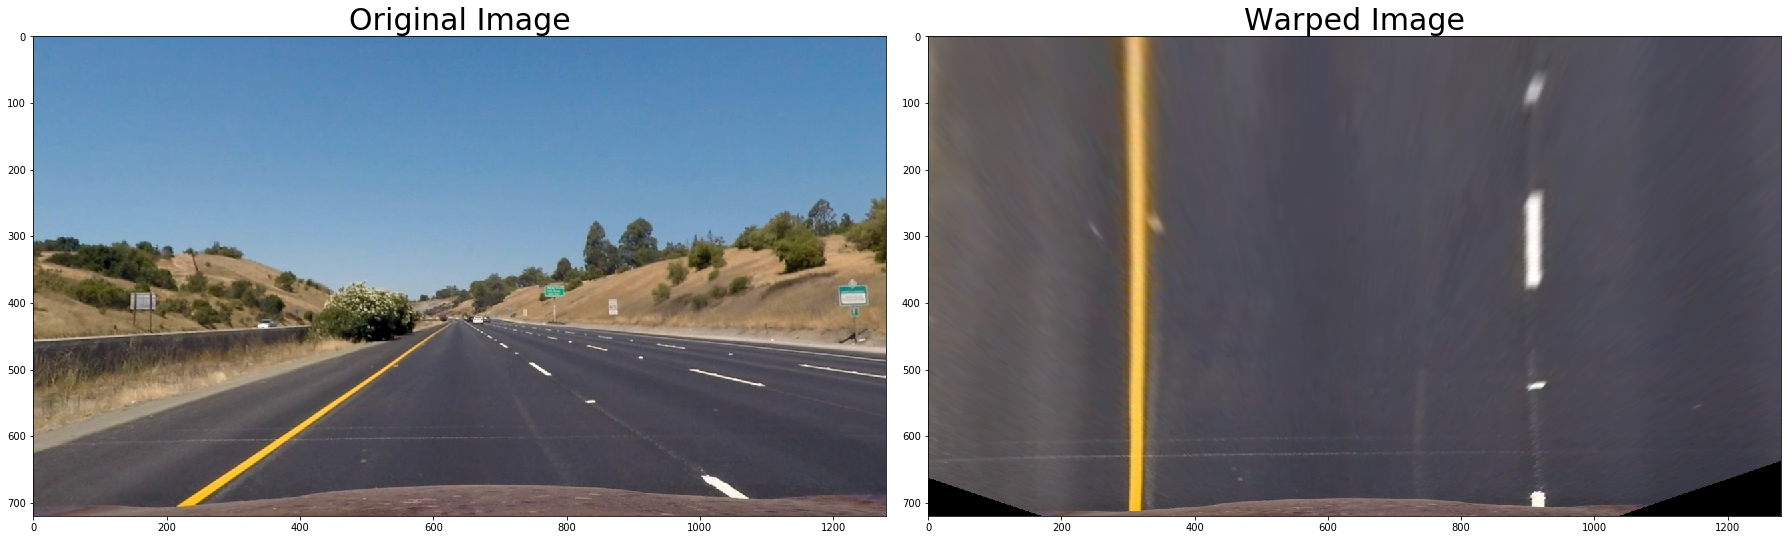

In [6]:
# Visualize original and warped image of one example
img = mpimg.imread('./test_images/straight_lines1.jpg')

img = cv2.undistort(img, mtx, dist, None, mtx) #undistort image
warped_img = warp_image(img, M) # perspective transform

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize = 30)

## Gradients and Color Threshold

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    return scaled_sobel, binary_output

In [8]:
def mag_thresh(image, mag_thresh=(0, 255), sobel_kernel=3):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return gradmag, binary_output

In [9]:
def dir_thresh(image, thresh=(0, np.pi/2), sobel_kernel=3):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    abs_gradient_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Rescale to 8 bit
    scale_factor = np.max(abs_gradient_dir) / 255
    gradient_dir = (abs_gradient_dir / scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(abs_gradient_dir)
    binary_output[(abs_gradient_dir >= thresh[0]) & (abs_gradient_dir <= thresh[1])] = 1
    return gradient_dir, binary_output

In [10]:
def gradient_thresh(img,plot_images=True):
    abs_threshold=(10, 100)
    mag_threshold=(10,255)
    dir_threshold=(np.pi/6, np.pi/2)
    
    gradient_sobelx, binary_sobelx = abs_sobel_thresh(img, 'x', abs_threshold)
    gradient_mag, binary_mag = mag_thresh(img, mag_threshold)
    gradient_dir, binary_dir = dir_thresh(img, dir_threshold)

    gradient_combined = np.zeros_like(binary_dir)
    gradient_combined[(binary_sobelx == 1) & (binary_dir == 1)] = 1

    # plot gradient images
    if plot_images == True:
        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 8))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=12)
        ax2.imshow(binary_sobelx, cmap='gray')
        ax2.set_title('Sobel X Binary ({},{})'.format(abs_threshold[0], abs_threshold[1]), fontsize=12)
        ax3.imshow(binary_mag, cmap='gray')
        ax3.set_title('Magnitude Binary ({},{})'.format(mag_threshold[0], mag_threshold[1]), fontsize=12)
        ax4.imshow(binary_dir, cmap='gray')
        ax4.set_title('Direction Binary ({:.2},{:.2})'.format(dir_threshold[0], dir_threshold[1]), fontsize=12)
        ax5.imshow(gradient_combined, cmap='gray')
        ax5.set_title('Gradient Combined Image', fontsize=12)
    return gradient_combined

In [11]:
# The method of color threshold refers to Subodh Malgonde. 
# The website is : https://github.com/subodh-malgonde/advanced-lane-finding
def color_thresh(img, plot_images=True):
    r_threshold=(210, 255)
    g_threshold=(190, 255)
    s_threshold=(100, 255)
    l_threshold=(120, 255)
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    r_channel = img[:, :, 2]
    g_channel = img[:, :, 1]
    s_channel = hls[:, :, 2] 
    l_channel = hls[:, :, 1] 

    # threshold r channel for detecting white lanes  well
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_threshold[0]) & (r_channel <= r_threshold[1])] = 1
    
    # threshold g channel
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= g_threshold[0]) & (g_channel <= g_threshold[1])] = 1
    
    # threshold s channel for detecting bright yellow and white lanes
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_threshold[0]) & (s_channel <= s_threshold[1])] = 1
    
    # threshold l channel for avoiding shadowy part of the road 
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_threshold[0]) & (l_channel <= l_threshold[1])] = 1
    
    # combine R & G channels of RGB to detect white lines well
    # combine L & S channels of HLS to detect bright yellow and white lines and to avoid shadows   
    rg_combined = np.zeros_like(r_channel)
    rg_combined[((r_binary == 1) & (g_binary == 1))] = 1
    
    sl_combined = np.zeros_like(s_channel)
    sl_combined[((s_binary == 1) & (l_binary == 1))] = 1
    
    color_combined = np.zeros_like(rg_combined)
    color_combined[(rg_combined == 1) | (sl_combined == 1)] = 1

    # plot color images
    if plot_images == True:
        f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(16, 8))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('RGB', fontsize=12)
        ax2.imshow(r_binary, cmap='gray')
        ax2.set_title('R Binary', fontsize=12)
        ax3.imshow(g_binary, cmap='gray')
        ax3.set_title('G Binary', fontsize=12)
        ax4.imshow(rg_combined, cmap='gray')
        ax4.set_title('R & G Binary', fontsize=12)
        ax5.axis('off')
        
        ax6.imshow(hls)
        ax6.set_title('HLS', fontsize=12)
        ax7.imshow(l_binary, cmap='gray')
        ax7.set_title('L Binary', fontsize=12)
        ax8.imshow(s_binary, cmap='gray')
        ax8.set_title('S Binary', fontsize=12)
        ax9.imshow(sl_combined, cmap='gray')
        ax9.set_title('S & L Binary', fontsize=12)
        ax10.imshow(color_combined, cmap='gray')
        ax10.set_title('Color Combined', fontsize=12)
        
    return color_combined

In [12]:
def threshold_pipeline(img, plot_images=False):
    gradient_combined = gradient_thresh(img, plot_images)

    color_combined = color_thresh(img, plot_images)
    
    combined_bianry = np.zeros_like(gradient_combined)
    combined_bianry[(gradient_combined == 1) | (color_combined == 1)] = 1

    return combined_bianry

#### Visualize the image using color transforms and gradients threshold

In [13]:
# Load calibration and warp matrix
calibration_result = pickle.load(open('calibration_result.p', 'rb'))
mtx = calibration_result['mtx']
dist = calibration_result['dist']
M = calibration_result['M']
M_inv = calibration_result['M_inv']

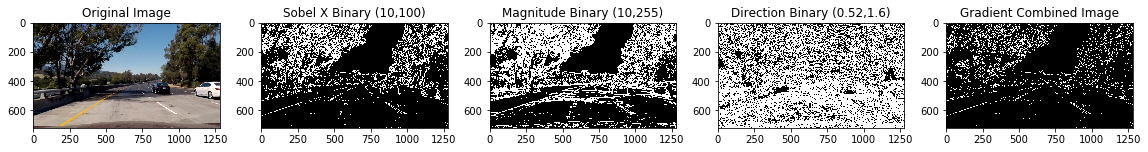

In [14]:
# show images using combined gradients threshold 
# Read and undistort image
img = cv2.imread('./test_images/test5.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
gradient_combined = gradient_thresh(img,plot_images=True)

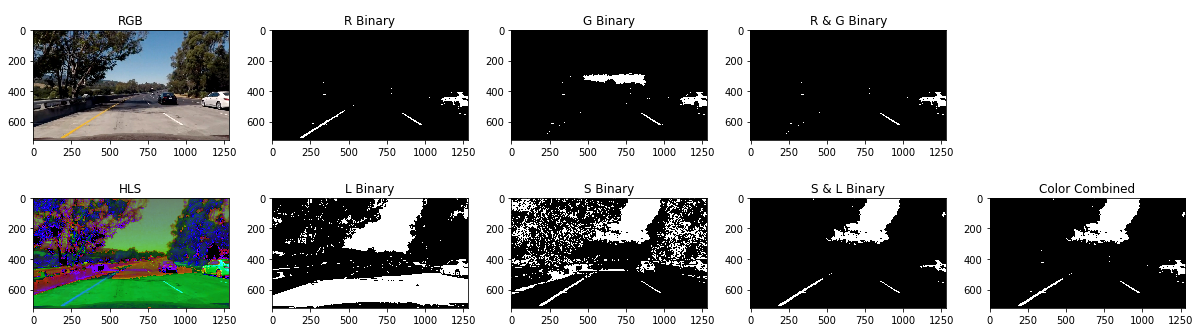

In [15]:
# Show images using color transforms 
color_combined = color_thresh(img, plot_images=True)
plt.subplots_adjust(left=0., right=1.0, top=0.6, bottom=0.05)

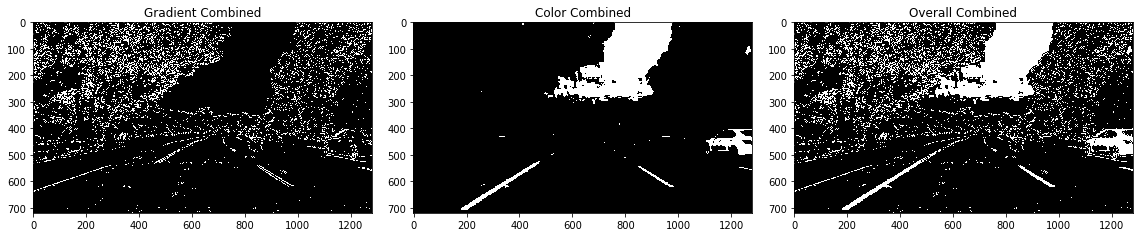

In [16]:
# Show overall combined image using gradients threshold and color transforms
threshold_bianry = np.zeros_like(gradient_combined)

threshold_bianry[(gradient_combined == 1) |  (color_combined == 1)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
f.tight_layout()
ax1.imshow(gradient_combined, cmap='gray')
ax1.set_title('Gradient Combined', fontsize=12)
ax2.imshow(color_combined, cmap='gray')
ax2.set_title('Color Combined', fontsize=12)
ax3.imshow(threshold_bianry, cmap='gray')
ax3.set_title('Overall Combined', fontsize=12)

## Sliding Window

In [17]:
def first_sliding_window(binary_warped, raw_img, M_inv):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # create an image to draw on and an image to show the selection window
    warped_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # set number of sliding window
    nwindows = 9
    # set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # set the width of the windows +/- margin
    margin = 100
    # set the minimum number of pixels found to recenter window
    minpix = 50
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # step through the window one by one
    for window in range(nwindows):
        # get window boundaries in x and y, left and right
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # draw the windows on the image
        cv2.rectangle(warped_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(warped_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # generate x and y values for plotting
    y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    left_fitx = left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2]
    right_fitx = right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2]

    warped_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    warped_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # plot lines with width
    for i in range(-2, 2):
        for j in range(0, len(y)-1):
            if left_fitx[j].astype(int) + i < raw_img.shape[1]:
                warped_img[y[j].astype(int), left_fitx[j].astype(int) + i] = [0, 255, 255]
            if right_fitx[j].astype(int) + i < raw_img.shape[1]:
                warped_img[y[j].astype(int), right_fitx[j].astype(int) + i] = [0, 255, 255]

    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    # fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    y_eval = 720
    left_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    # compute the offset from the center
    lane_center = (left_fitx[len(y)-1] + right_fitx[len(y)-1])/2.0
    center_offset = lane_center - binary_warped.shape[1]/2.0
    center_offset = center_offset*xm_per_pix
    # create mask poly
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inv, (raw_img.shape[1], raw_img.shape[0]))
    mask_img = cv2.addWeighted(raw_img, 1, newwarp, 0.3, 0)
    
    return warped_img, mask_img, left_fit, right_fit, left_radius, right_radius, center_offset

In [18]:
def second_sliding_window(binary_warped, raw_img, M_inv, left_fit, right_fit, left_fit_queue, right_fit_queue):
    # create an image to draw on and an image to show the selection window
    warped_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # get the mean value using the last 10 frames
    left_fit_mean = np.mean(left_fit_queue, axis=0)
    right_fit_mean = np.mean(right_fit_queue, axis=0)
        
    ## Check error between current coefficient and mean value of the previous frames
    err_L = np.sum((left_fit[0]-left_fit_mean[0])**2) 
    err_L = np.sqrt(err_L)
    if err_L>.0002: # bad frame
        left_fit = left_fit_mean
    else:
        left_fit = .5*left_fit+.5*left_fit_mean
    
    ## Check error between current coefficient and mean value of the previous frames
    err_R = np.sum((right_fit[0]-right_fit_mean[0])**2) 
    err_R = np.sqrt(err_R)
    if err_R>.0002: # bad frame
        right_fit = right_fit_mean
    else:
        right_fit = .5*right_fit+.5*right_fit_mean
      
    # generate x and y values for plotting
    y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2]
    right_fitx = right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2]
    warped_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    warped_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # plot lines with width
    for i in range(-2, 2):
        for j in range(0, len(y)-1):
            if left_fitx[j].astype(int) + i < raw_img.shape[1]:
                warped_img[y[j].astype(int), left_fitx[j].astype(int) + i] = [0, 255, 255]
            if right_fitx[j].astype(int) + i < raw_img.shape[1]:
                warped_img[y[j].astype(int), right_fitx[j].astype(int) + i] = [0, 255, 255]

    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    # fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    y_eval = 720
    left_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    # compute the offset from the center
    lane_center = (left_fitx[len(y)-1] + right_fitx[len(y)-1])/2.0
    center_offset = lane_center - binary_warped.shape[1]/2.0
    center_offset = center_offset*xm_per_pix
    # create mask poly
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inv, (raw_img.shape[1], raw_img.shape[0]))
    mask_img = cv2.addWeighted(raw_img, 1, newwarp, 0.3, 0)

    return warped_img, mask_img, left_fit, right_fit, left_radius, right_radius, center_offset

In [19]:
def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

def combine_images(threshold_bianry, warped_img, mask_img, left_radius, right_radius, center_offset):
    # resize images
    resized_warped_img = cv2.resize(warped_img, (0, 0), fx=0.4, fy=0.4)
    resized_thresh_img = cv2.resize(stack_arr(threshold_bianry*255), (0, 0), fx=0.4, fy=0.4)
    resized_mask_img = cv2.resize(mask_img, (0, 0), fx=0.8, fy=0.8)
    # put text on image
    cv2.putText(resized_warped_img, 'perpective transform', (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, color=(0, 255, 255),
                thickness=1)
    cv2.putText(resized_thresh_img, 'threshold', (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, color=(0, 255, 255),
                thickness=1)
    cv2.putText(resized_mask_img, 'left:{0:.2f}m, right:{1:.2f}m'.format(left_radius, right_radius), (50, 50),
                cv2.FONT_HERSHEY_COMPLEX, 1, color=(0, 255, 255), thickness=2)
    cv2.putText(resized_mask_img, 'center offset:{0:.2f}m'.format(center_offset), (50, 100),
                cv2.FONT_HERSHEY_COMPLEX, 1, color=(0, 255, 255), thickness=2)
    # create an image combining all resezed images
    all_img = cv2.resize(mask_img, (0, 0), fx=1.2, fy=0.8)
    size_x = mask_img.shape[0]
    size_y = mask_img.shape[1]
    # left part
    all_img[0:size_x * 0.8, 0:size_y * 0.8] = resized_mask_img
    # top right part
    all_img[0:size_x * 0.4, size_y * 0.8:size_y * 1.2] = resized_thresh_img
    # bottom right part
    all_img[size_x * 0.4:size_x * 0.8, size_y * 0.8:size_y * 1.2] = resized_warped_img

    return all_img

## Video Pipeline

In [20]:
import collections

def process_pipeline(img):
    global first
    global left_fit, right_fit
    global left_fit_queue, right_fit_queue

    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Use color transforms and gradients to create a thresholded binary image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    threshold_bianry = threshold_pipeline(img, plot_images=False)
    # Perspective transform
    binary_warped = warp_image(threshold_bianry, M)
    
    # Sliding window
    if first:
        left_fit_queue = collections.deque(maxlen = 10) # store the last frames
        right_fit_queue = collections.deque(maxlen = 10) # store the last frames       
        warped_img, mask_img, left_fit, right_fit, left_radius, right_radius, center_offset = first_sliding_window(binary_warped, img, M_inv)
        first = False
    else:
        warped_img, mask_img, left_fit, right_fit, left_radius, right_radius, center_offset = second_sliding_window(binary_warped, 
                                                                                                                    img, M_inv, left_fit, right_fit, left_fit_queue, right_fit_queue)
    left_fit_queue.append(left_fit)
    right_fit_queue.append(right_fit)
    all_img = combine_images(threshold_bianry, warped_img, mask_img, left_radius, right_radius, center_offset)
    all_img = cv2.cvtColor(all_img, cv2.COLOR_BGR2RGB)
    return all_img 


#### Visualize the image using sliding window

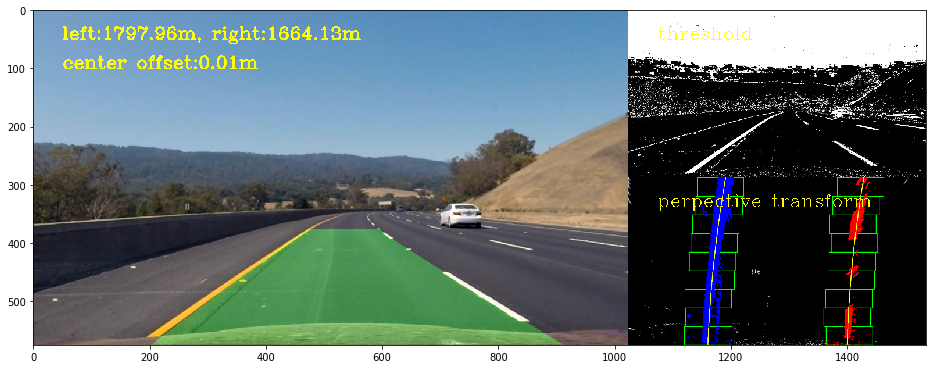

In [21]:
img = mpimg.imread('./test_images/test3.jpg')
first = True
all_img = process_pipeline(img)
f, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
ax1.imshow(all_img)

#### Visualize the video

In [22]:
first = True
out_video = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_pipeline)
%time out_clip.write_videofile(out_video, audio=False)

[MoviePy] >>>> Building video project_result_055filter.mp4
[MoviePy] Writing video project_result_055filter.mp4


100%|█████████▉| 1260/1261 [08:03<00:00,  2.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result_055filter.mp4 

CPU times: user 28min 3s, sys: 51.8 s, total: 28min 55s
Wall time: 8min 4s
